In [52]:
###############################################################################################
# Versión 3aCOMPARA
# SEGUN LOS "n" DIAS PREVIOS (VENTANA DE "n" VALORES), PREDICE los "ventSalida" DÍAS SIGUIENTES
# del atributo seleccionado
# Idéntico a versión 3a, pero utiliza mismo dataset que en las pruebas del modelo SARIMA para
# comparar resultados
###############################################################################################

In [53]:
# Parámetros del algoritmo

# Definir el número de días de la ventana de entrada (días previos a considerar para la predicción)
n = 30

# Definir el número de días a predecir por cada ventana de entrada
ventSalida = 1

# seleccionar un atributo a predecir
atributo = 'O3'

# Definir número de epoch máximo para entrenamiento
max_epochs = 50

In [54]:
# librerías necesarias

import pandas as pd
import numpy as np
import plotly 
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

np.random.seed(200)
tf.random.set_seed(200)

# Configuración general de las figuras que representaremos
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 10)

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# Este dataset tiene todas las fechas disponibles de Av. de Francia (solo esa estación) para el O3


path = '/content/drive/MyDrive/datoscsv/'
df = pd.read_csv(path + 'prueba_sarima.csv', sep=';', index_col='FECHA', parse_dates=['FECHA'])

# Recuperar la fecha como campo
df.insert(0, 'FECHA', df.index.strftime('%Y-%m-%d'))

In [57]:
# eliminar filas sin el atributo para probar

df = df[df[atributo].notnull()]

df.isnull().sum()

FECHA    0
O3       0
dtype: int64

In [58]:
df

,FECHA,O3
FECHA,,
2009-01-01,2009-01-01,18.0
2009-01-02,2009-01-02,13.0
2009-01-03,2009-01-03,10.0
2009-01-04,2009-01-04,28.0
2009-01-05,2009-01-05,16.0
...,...,...
2022-03-27,2022-03-27,91.0
2022-03-28,2022-03-28,70.0
2022-03-29,2022-03-29,64.0


In [59]:
# Modelo LSTM

In [60]:
# Vamos a coger del 2013 al 2018 para entrenamiento y los datos del 2019 para testear
# Para poder introducir los datos en una red neuronal hay que transformarlos, ya que solo funciona con arrays
df2 = df[[atributo]]
train = df2[:'2018']    # guardar desde fecha más antigua hasta final de 2018
test = train.iloc[-n:]  # guardar los "n" últimos dias del 2018
test = test.append(df2['2019'], ignore_index=False) # añadir a los "n" días del 2018 + el 2019 completo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


In [61]:
train

,O3
FECHA,
2009-01-01,18.0
2009-01-02,13.0
2009-01-03,10.0
2009-01-04,28.0
2009-01-05,16.0
...,...
2018-12-27,10.0
2018-12-28,19.0
2018-12-29,19.0


In [62]:
test

,O3
FECHA,
2018-12-02,28.0
2018-12-03,23.0
2018-12-04,13.0
2018-12-05,16.0
2018-12-06,17.0
...,...
2019-12-27,16.0
2019-12-28,17.0
2019-12-29,30.0


In [63]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
O3,4838.0,49.620814,18.127855,4.0,38.0,51.0,62.0,152.0


In [64]:
# Tiene que ser un vector columna
train.shape

(3652, 1)

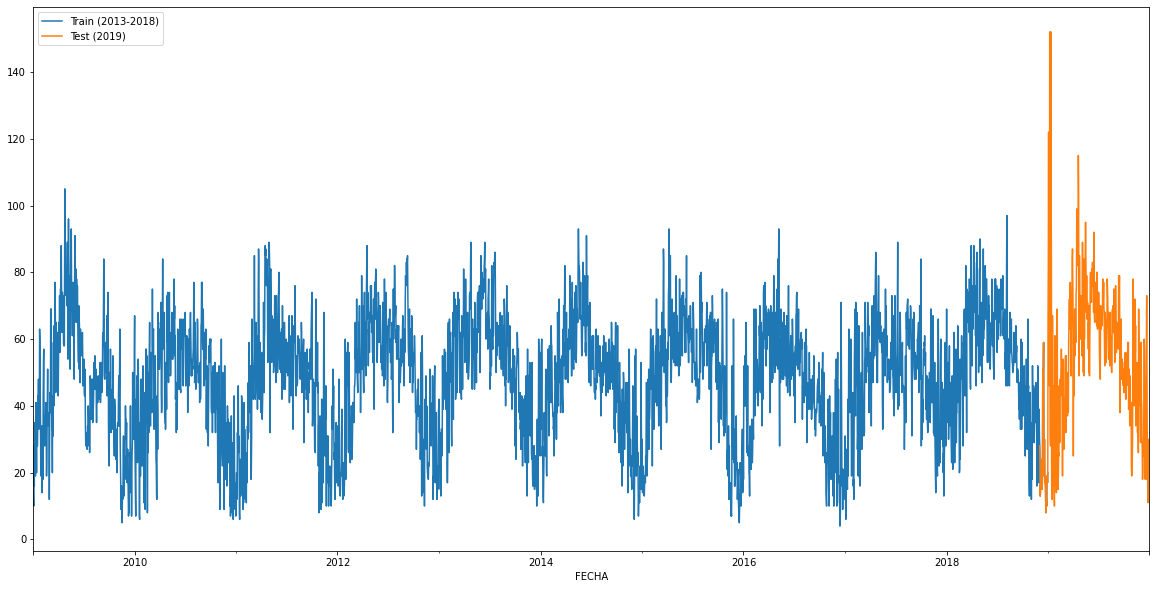

In [65]:
train[atributo].plot(legend=True)
test[atributo].plot(legend=True)

plt.legend(['Train (2013-2018)', 'Test (2019)'])
plt.show()

## **Normalización**

In [66]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

## **Estructura datos entrada**

In [67]:
# Hay que crear una estructura de datos para indicarle a la red lo que tiene que recordar 
# y poder hacer una predección en base a datos anteriores
X_train = []
y_train = []

# Estructura de datos con "n" pasos y uno o mas valores de salida
# "n" timesteps significa que para un día dado la red es capaz de mirar los "n" días anteriores:
# "n" valores anteriores al día actual y en base a esa información predice los "ventSalida" dias futuros 
for i in range(n,len(train_scaled)):
    # X: para cada día hacemos un bloque correspondiente al valor de los "n" días anteriores
    X_train.append(train_scaled[i-n:i,0])
    # Y: el valor del día
    y_train.append(train_scaled[i,0])

# Tenemos una matriz donde cada fila contiene "n" columnas correspondientes a los "n" días anteriores
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train para que se ajuste al modelo en Keras
# añadiendo una nueva dimensión 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(3622, 30, 1)
(3622,)


## **Modelo**

Creamos un modelo secuencial al que iremos añadiendo capas, que pueden ser:

*   Dense: Capa de neuronas artificiales
*   LSTM: Capa de neuronas con capacidad de memoria
*   Dropout: Es una técnica de regularización que elimina conexiones neuronales para evitar el sobreajuste, de esta forma se evita que el algoritmo memorice los datos en vez de aprender de ellos. 

Antes de crear la Red LSTM debemos reajustar los sets que acabamos de obtener, para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un vector de "n" x 1.

Para el caso de cada una de las salidas (almacenadas en y_train) debemos simplemente especificar que su tamaño, que será igual al número de valores predichos por la red neuronal.

In [68]:
# Definimos el tamaño de los datos de entrada y de salida
dim_entrada = (X_train.shape[1],1)

dim_salida = ventSalida

modelo = Sequential()
# Añadimos la primera capa y especificamos el número de neuromas (50) y el tamaño de cada dato de entrada
modelo.add(LSTM (units=50, return_sequences=True, input_shape=dim_entrada))
modelo.add(Dropout(0.2))
# Añadimos la segunda capa
modelo.add(LSTM (units=50, return_sequences=True))
modelo.add(Dropout(0.2))
# Añadimos la tercera capa
modelo.add(LSTM (units=50, return_sequences=True))
modelo.add(Dropout(0.2))
# Añadimos la cuarta capa
modelo.add(LSTM (units=50))
modelo.add(Dropout(0.2))
# Añadimos la capa de salida (Dense) y especificamos que el campo de salida es igual a dim_salida
modelo.add(Dense(units=dim_salida))

## **Compilación**

*   El optimizador se encarga de optimizar y actualizar los pesos de la red. Usaremos el algoritmo adam que es el que mejores resultados nos aporta.
*   loss: Cuando la red hace una predicción coge el valor real y lo compará con la predicción. Para calcular el error de predicción, se utilizará el método error cuadrático medio. 

In [69]:
# Compilamos el modelo definiendo la función de error (loss) y el método que se usa para minimizarla (optimizer)
modelo.compile(optimizer='adam', loss='mean_squared_error')

## **Entrenamiento**

*   epochs: Especificamos las veces que la red propagara el error hacia atrás para aprender y hacer mejores predicciones. Es la cantidad de veces que la red realizará una predicción y propagara hacia atrás el error, para aprender de él y hacer mejores predicciones
*   batch_size: Para este proceso de predicción, corrección y propagación hacia atrás, no lo haremos con un solo bloque de datos, si no de 32. Si no el entrenamiento sería demasiado pesado para la red, el tener que actualizar los pesos a cada dato. Vamos actualizando los pesos con bloques de datos.

In [70]:
# Entrenamos el modelo con epochs=epoch_max (nº de iteraciones) y batch_size=32 (lotes de 32 datos)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

modelo.fit(X_train,y_train,epochs=max_epochs, batch_size=32, callbacks=[callback])

Epoch 1/50
114/114 [==============================] - 17s 78ms/step - loss: 0.0249
Epoch 2/50
114/114 [==============================] - 9s 78ms/step - loss: 0.0190
Epoch 3/50
114/114 [==============================] - 8s 72ms/step - loss: 0.0177
Epoch 4/50
114/114 [==============================] - 9s 77ms/step - loss: 0.0177
Epoch 5/50
114/114 [==============================] - 9s 77ms/step - loss: 0.0173
Epoch 6/50
114/114 [==============================] - 8s 73ms/step - loss: 0.0165
Epoch 7/50
114/114 [==============================] - 9s 76ms/step - loss: 0.0164
Epoch 8/50
114/114 [==============================] - 8s 72ms/step - loss: 0.0158
Epoch 9/50
114/114 [==============================] - 8s 70ms/step - loss: 0.0154
Epoch 10/50
114/114 [==============================] - 8s 70ms/step - loss: 0.0149
Epoch 11/50
114/114 [==============================] - 8s 70ms/step - loss: 0.0142
Epoch 12/50
114/114 [==============================] - 8s 73ms/step - loss: 0.0138
Epoch 13/50


## **Predicciones**

Hay que preparar los datos como en el caso de train, esto es, hacemos bloques de "n" días para predecir el valor de la acción en el siguiente día.

In [71]:
test_scaled = sc.fit_transform(test)

X_test = []
for i in range(n,len(test_scaled), ventSalida):
    X_test.append(test_scaled[i-n:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Realizamos la prediccion y aplicamos normalización inversa para que esté en escala real
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

print(len(prediccion))
print(prediccion)

prediccion = np.reshape(prediccion, (prediccion.shape[0]*prediccion.shape[1], 1))

365
[[ 21.518051]
 [ 56.45283 ]
 [ 59.076435]
 [ 88.7932  ]
 [ 51.915794]
 [ 50.537346]
 [ 46.29717 ]
 [112.23782 ]
 [ 64.52768 ]
 [ 40.120937]
 [ 39.103683]
 [113.0459  ]
 [ 73.06019 ]
 [ 74.14747 ]
 [ 38.37858 ]
 [ 31.344707]
 [ 28.55309 ]
 [ 64.078316]
 [ 41.402283]
 [ 27.879831]
 [ 27.876463]
 [ 36.480526]
 [ 45.497993]
 [ 23.219852]
 [ 22.320532]
 [ 57.97262 ]
 [ 49.663742]
 [ 32.97546 ]
 [ 42.314247]
 [ 30.197144]
 [ 35.277565]
 [ 22.163494]
 [ 58.917725]
 [ 52.411964]
 [ 57.20508 ]
 [ 35.56062 ]
 [ 28.072266]
 [ 23.904781]
 [ 25.780975]
 [ 29.324158]
 [ 27.281494]
 [ 42.527046]
 [ 33.33986 ]
 [ 29.846819]
 [ 37.036034]
 [ 43.00736 ]
 [ 38.93607 ]
 [ 44.79446 ]
 [ 47.329166]
 [ 49.62863 ]
 [ 47.07711 ]
 [ 47.486168]
 [ 36.058006]
 [ 26.4885  ]
 [ 37.604362]
 [ 48.38252 ]
 [ 34.21244 ]
 [ 34.877895]
 [ 29.964447]
 [ 35.481834]
 [ 39.189945]
 [ 38.767937]
 [ 41.301697]
 [ 47.441124]
 [ 48.054897]
 [ 33.18881 ]
 [ 52.08689 ]
 [ 41.01306 ]
 [ 44.623074]
 [ 42.9725  ]
 [ 39.16098 ]
 [

## **Visualización del resultado**

In [72]:
resultados = test.tail(len(test)-n)
resultados['Prediccion'] = prediccion[0:len(resultados)]

resultados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,Prediccion
FECHA,,
2019-01-01,66.0,21.518051
2019-01-02,83.0,56.452831
2019-01-03,122.0,59.076435
2019-01-04,73.0,88.793198
2019-01-05,53.0,51.915794
...,...,...
2019-12-27,16.0,20.410065
2019-12-28,17.0,23.436110
2019-12-29,30.0,22.332970


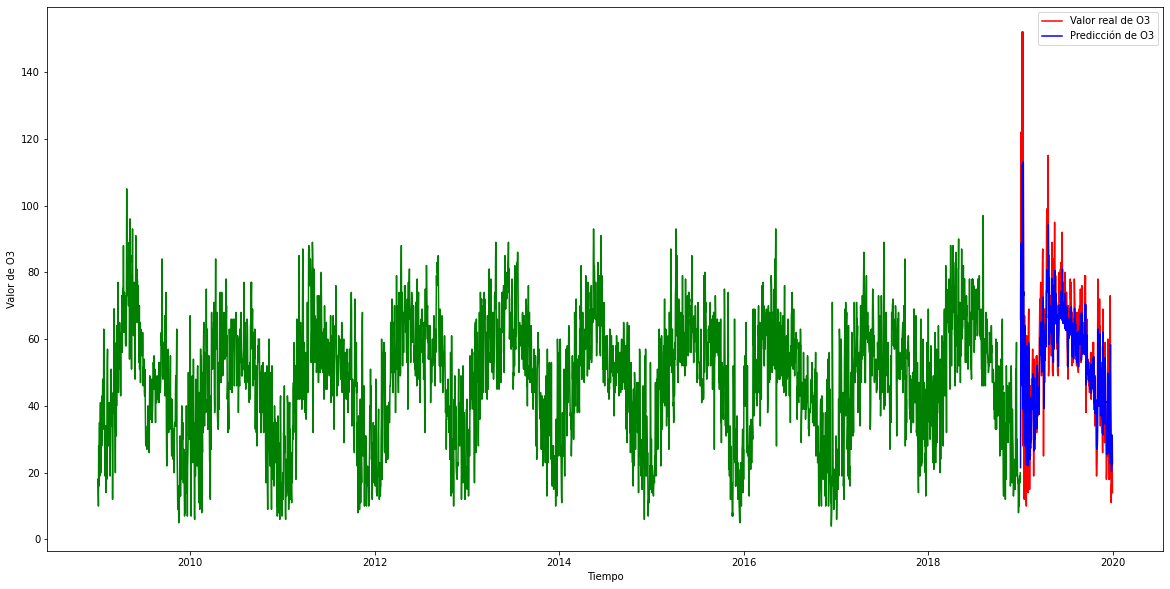

In [73]:
plt.plot(train[atributo], color='green')
plt.plot(resultados[atributo], color='red', label='Valor real de ' + atributo)
plt.plot(resultados['Prediccion'], color='blue', label='Predicción de '+ atributo)
plt.xlabel('Tiempo')
plt.ylabel('Valor de ' + atributo)
plt.legend()
plt.show()

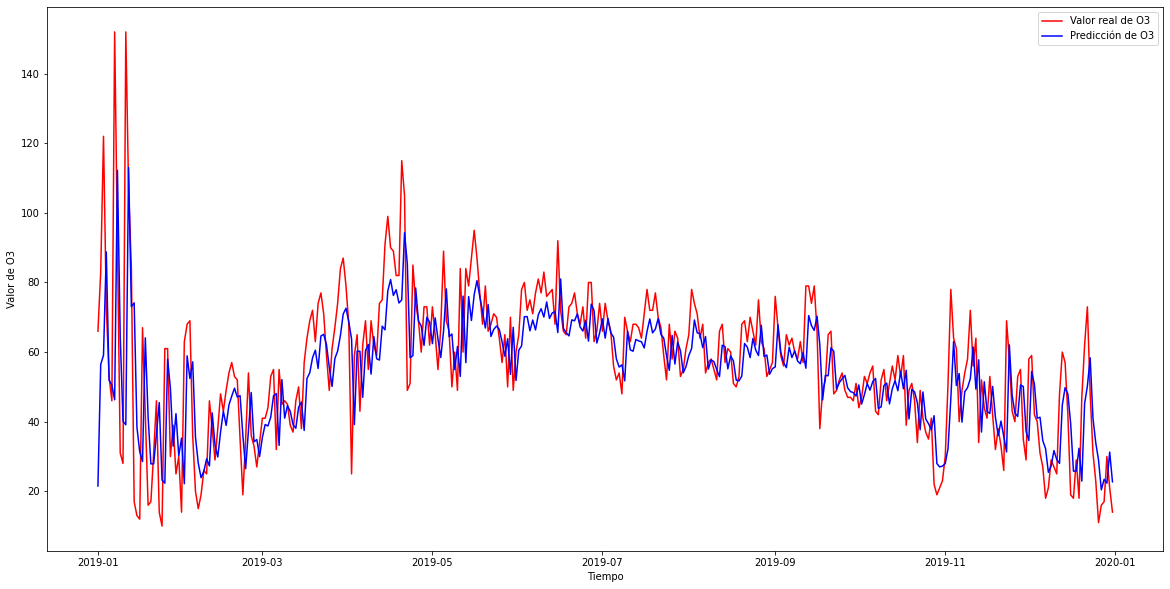

In [74]:
plt.plot(resultados[atributo], color='red', label='Valor real de ' + atributo)
plt.plot(resultados['Prediccion'], color='blue', label='Predicción de ' + atributo)
plt.xlabel('Tiempo')
plt.ylabel('Valor de ' + atributo)
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Error absoluto medio en la predicción
mae = mean_absolute_error(resultados['Prediccion'], resultados[atributo])
rmse = sqrt(mean_squared_error(resultados['Prediccion'], resultados[atributo]))
print('Error cuadrático medio: %.3f' % rmse)
print('  Error absoluto medio: %.3f' % mae)

Error cuadrático medio: 15.378
  Error absoluto medio: 10.145


resultados segun seed:

*   100: 15.68 - 10.70
*   200: 
*   300: 
*   400: 10.05

